In [1]:
# Import all the required Libraries

import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import networkx as nx
import math
import csv
import matplotlib.pylab as pyl
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read all the event files of all the leagues
events=[]
leagues = ['England']
for league in leagues:
    events.append(pd.read_json('dataset\events\events_%s.json' %league))

In [3]:
# Read all the matches in all the leagues
matches=[]
leagues = ['England']
for match in leagues:
    matches.append(pd.read_json('dataset\matches\matches_%s.json' %match))

In [4]:
# Read required input files


player_df = pd.read_json("dataset\players.json")
team_data_df = pd.read_json("dataset/teams.json") 





In [5]:
# Data Preprocessing

# Conversion of special character into normal character in players name

def jsonparse(x):
    s = '"'+x+'"'
    s = s.replace('	', '')
    return json.loads(s.replace('	', ''))

player_df['shortName'] = player_df['shortName'].map(lambda x: jsonparse(x))


# Addition of a player name based on player id in the event dataframe

a=player_df[['wyId','shortName']]    # Selecting the player name from player dataframe

for event in events:    
    b=event[['playerId']]             # Selecting the playerId from the event dataframe
    c=b.merge(a,how='left', left_on='playerId', right_on='wyId')  # Merging both the dataframe
    event["player"] = c.shortName           # Addition of the player name in the event dataframe



In [8]:
def passing_network(event_df, match_df, match_Id = 2499954):
    
 
    team_temp_list = []   # Temporary team metric list
    
   
    match_description = match_df.label.values[0] 
    
    
   
    # Filtering the passing events
    pass_events = event_df[event_df.eventName == 'Pass']
    pass_events = pass_events.dropna(how='any',axis=0)

    
    # Altering the time of the event in the second half by adding the maximum time of the first half
    first_half_max_duration = np.max(pass_events[pass_events['matchPeriod'] == '1H']['eventSec'])
    pass_events.loc[pass_events.matchPeriod == "2H", "eventSec"] = pass_events.eventSec + first_half_max_duration  
    
   
      
        
    # Segregation of teams  and team passes in the match
    
    team_id=pass_events.teamId.unique()
    
    # Team names
    team1_name = team_data_df.name[team_data_df['wyId']==team_id[0]].values[0]
    team2_name = team_data_df.name[team_data_df['wyId']==team_id[1]].values[0]
    
    Teams_Played = team1_name + '-' + team2_name
    
    # Seperation of the passess 
    team1_pass_events = pass_events[pass_events['teamId'] == team_id[0]]
    team2_pass_events = pass_events[pass_events['teamId'] == team_id[1]]       
       

    # Result of the match
    winner = match_df.winner.values[0]

    
    if winner == team_id[0]:
        team_temp_list.append("Team_1")
    else:
        if winner == team_id[1]:
            team_temp_list.append("Team_2")
        else:
            team_temp_list.append("Draw")       
        

    
        

#   split pass between team1 and team2 
    
    team_1 = pd.DataFrame()
    
    team_1['sender'] = team1_pass_events.player
    team_1['receiver'] = team1_pass_events.player.shift(-1).dropna()
    
    team_2 = pd.DataFrame()
    team_2['sender'] = team2_pass_events.player
    team_2['receiver'] = team2_pass_events.player.shift(-1).dropna()
    
 


    #create dataframe of sender and receiver with number of passes for team 1
    
    df_team1 = []
    for i,row in team_1.iterrows():
        if row['sender'] == row['receiver']:
            pass        
        else:
            df_team1.append([row['sender'],row['receiver']])
    df_team1 = pd.DataFrame(df_team1, columns=['sender','receiver']) 
    
    # Dataframe with total number of passess between two player of team 1
    df_team1_count = df_team1.groupby(['sender','receiver']).size().reset_index(name="No_of_Passes")
    
      
         
    # Total number of passess in team 1 
   
    team1_total_passes = df_team1_count.No_of_Passes.sum()     
       
    



    # create dataframe of sender and receiver with number of passes for team 2

    df_team2 = []
    for i,row in team_2.iterrows():
        if row['sender'] == row['receiver']:
            pass        
        else:
            df_team2.append([row['sender'],row['receiver']])
    df_team2 = pd.DataFrame(df_team2, columns=['sender','receiver']) 
    
    # Dataframe with total number of passess between two player of team 2
    df_team2_count = df_team2.groupby(['sender','receiver']).size().reset_index(name="No_of_Passes")
    
    # Total number of passess in team 2 
   
    team2_total_passes = df_team2_count.No_of_Passes.sum()  
   

    

    # Calculation of position of the player for team 1   

    pos1 = {}
    actual_pos1 = {}
    pos1_relative = {}  # Position of the player with respect to football pitch layout
    
        
    for player in list(df_team1['sender'].unique()):
        x, y = [], []
        df_match_player = pass_events[pass_events.player==player]
        for i,row in df_match_player.iterrows():
            x.append(row['positions'][0]['x'])            
            y.append(row['positions'][0]['y'])
            
        # Mean position of the player
        actual_pos1[player] = (int(np.mean(x)), int(np.mean(y)))
        pos1[player] = (int(105 - np.mean(x)), int(69-(np.mean(y))))
        pos1_relative[(player)] = (int(105 - np.mean(x)), int(69-(np.mean(y)/100 * 69)))
        
        
       
    
    # Calculation of the average possession position of the team 1
    pos1_df =  pd.DataFrame(actual_pos1).T.reset_index()
    pos1_df.columns = ['Player','X','Y']
    
    team1_possession_mean_x = pos1_df["X"].mean()
    team1_possession_mean_y = pos1_df["Y"].mean()
    
    
  
        
    # Calculation of position of the player for team 2  

    pos2 = {}
    actual_pos2 = {}
    pos2_relative = {}  # Position of the player with respect to football pitch layout
    
    for player in list(df_team2['sender'].unique()):
        x, y = [], []
        df_match_player = pass_events[pass_events.player==player]
        for i,row in df_match_player.iterrows():
            x.append(row['positions'][0]['x'])
            y.append(row['positions'][0]['y'])
        
        # Mean position of the players during the match
                
        actual_pos2[player] = (int(np.mean(x)), int(np.mean(y)))
        pos2[(player)] = (int(np.mean(x)), int(np.mean(y)))        
        pos2_relative[(player)] = (int(np.mean(x)), int(np.mean(y)/100 * 69))
        
    
   
     # Calculation of the average possession position of the team 2
    pos2_df =  pd.DataFrame(actual_pos2).T.reset_index()
    pos2_df.columns = ['Player','X','Y']
    
    team2_possession_mean_x = pos2_df["X"].mean()
    team2_possession_mean_y = pos2_df["Y"].mean()   
 
    
    
  # Passing Network for the team 1
    
    g = nx.Graph()
    for i,row in df_team1_count.iterrows():
        g.add_edge(row['sender'],row['receiver'],weight=row['No_of_Passes'])
    deg = dict(g.degree)
    team1_degree = 0
    for player_deg in deg.values():
        team1_degree = team1_degree + player_deg
    
    
    team1_centrality = round(nx.global_reaching_centrality(g),2)
    team1_avg_clustering = round(nx.average_clustering(g),2)
    team1_connectivity = round(nx.algebraic_connectivity(g),2)
    team1_density = round(nx.density(g),2)
    team1_diameter = nx.diameter(g)
    team1_asp = round(nx.average_shortest_path_length(g),2)
    
    

       
    
    # Passing Network for the team 2
    
    r = nx.Graph()
    for i,row in df_team2_count.iterrows():
        r.add_edge(row['sender'],row['receiver'],weight=row['No_of_Passes'])
    deg = dict(r.degree)
    team2_degree = 0
    for player_deg in deg.values():
        team2_degree = team2_degree + player_deg
    
    team2_centrality = round(nx.global_reaching_centrality(r),2)
    team2_avg_clustering = round(nx.average_clustering(r),2)
    team2_connectivity =round(nx.algebraic_connectivity(r),2)
    team2_density = round(nx.density(r),2)
    team2_diameter = nx.diameter(r)
    team2_asp = round(nx.average_shortest_path_length(r),2)
    


        
        
    # Append all the features in the original list
     
    team_temp_list.append(Teams_Played)                                      
    team_temp_list.append(team1_name)
    team_temp_list.append(team2_name)
    team_temp_list.append(team1_total_passes)
    team_temp_list.append(team2_total_passes)
    team_temp_list.append(round(team1_possession_mean_x,2))
    team_temp_list.append(round(team1_possession_mean_y,2))
    team_temp_list.append(round(team2_possession_mean_x,2))
    team_temp_list.append(round(team2_possession_mean_y,2))
    team_temp_list.append(team1_degree)
    team_temp_list.append(team2_degree)
    team_temp_list.append(team1_centrality)
    team_temp_list.append(team2_centrality)
    team_temp_list.append(team1_avg_clustering)
    team_temp_list.append(team2_avg_clustering)
    team_temp_list.append(team1_connectivity)
    team_temp_list.append(team2_connectivity)
    team_temp_list.append(team1_density)
    team_temp_list.append(team2_density) 
    team_temp_list.append(team1_diameter)
    team_temp_list.append(team2_diameter)
    team_temp_list.append(team1_asp)
    team_temp_list.append(team2_asp)
    
    

    
    teams_metrics_list.append(team_temp_list)
    
   

    
  
    
    


### Machine Learning

In [9]:
# Generate the network metrics for all the matches

teams_metrics_list = []  
for idx, match_df in enumerate(matches):
    events_df = events[idx]
    for match_id in match_df.wyId:
        row = match_df[match_df.wyId == match_id]
        event_df = events_df[events_df.matchId == match_id]
        passing_network(event_df, row, match_id)

In [10]:
data=np.array(teams_metrics_list)

data.shape


(380, 24)

In [11]:
columns = ['Winner','Teams','Team_1', 'Team_2', 'T1_Passes','T2_Passes','T1_possession_X','T1_possession_Y','T2_possession_X','T2_possession_Y','T1_degree','T2_degree','T1_Centrality','T2_Centrality','T1_Avg_Cluster','T2_Avg_Cluster','T1_Connectivity','T2_Connectivity','T1_Density','T2_Density','T1_Diameter','T2_Diameter','T1_ASP','T2_ASP']
feature_df = pd.DataFrame(data, columns=columns) 

In [12]:
temp = feature_df['Winner']
feature_df.drop(labels=['Winner'], axis=1, inplace = True)
feature_df.insert(23, 'Winner', temp)
feature_df

,Teams,Team_1,Team_2,T1_Passes,T2_Passes,T1_possession_X,T1_possession_Y,T2_possession_X,T2_possession_Y,T1_degree,...,T2_Avg_Cluster,T1_Connectivity,T2_Connectivity,T1_Density,T2_Density,T1_Diameter,T2_Diameter,T1_ASP,T2_ASP,Winner
0,AFC Bournemouth-Burnley,AFC Bournemouth,Burnley,356,398,47.36,42.0,56.71,46.14,146,...,0.83,8.2,1.05,0.8,0.74,2,3,1.2,1.27,Team_1
1,Crystal Palace-West Bromwich Albion,Crystal Palace,West Bromwich Albion,525,357,50.43,47.79,48.57,50.57,140,...,0.83,7.22,6.45,0.77,0.74,2,2,1.23,1.26,Team_1
2,Huddersfield Town-Arsenal,Huddersfield Town,Arsenal,380,482,48.21,46.43,46.29,45.0,146,...,0.91,3.94,12.23,0.8,0.86,2,2,1.2,1.14,Team_2
3,Liverpool-Brighton & Hove Albion,Liverpool,Brighton & Hove Albion,703,241,56.14,53.43,39.57,52.64,138,...,0.83,7.07,7.04,0.76,0.77,2,2,1.24,1.23,Team_1
4,Manchester United-Watford,Manchester United,Watford,428,412,44.0,47.21,49.29,49.5,140,...,0.85,4.17,6.74,0.77,0.78,2,2,1.23,1.22,Team_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Everton-Stoke City,Everton,Stoke City,461,253,50.5,51.5,53.08,48.92,146,...,0.87,6.24,5.08,0.8,0.79,2,2,1.2,1.21,Team_1
376,Swansea City-Southampton,Swansea City,Southampton,321,488,44.29,53.93,54.43,44.0,120,...,0.88,3.78,7.18,0.66,0.77,3,2,1.35,1.23,Draw
377,West Bromwich Albion-AFC Bournemouth,West Bromwich Albion,AFC Bournemouth,225,588,45.62,53.46,56.14,50.5,122,...,0.83,6.72,6.18,0.78,0.73,2,2,1.22,1.27,Team_1
378,Watford-Liverpool,Watford,Liverpool,355,433,48.57,56.64,45.71,52.43,134,...,0.87,4.14,1.86,0.74,0.68,2,2,1.26,1.32,Draw


In [13]:
# Converting columns value into integer and floats

feature_df.T1_Passes = feature_df.T1_Passes.apply(lambda x: int(x))
feature_df.T2_Passes = feature_df.T2_Passes.apply(lambda x: int(x))
feature_df.T1_possession_X = feature_df.T1_possession_X.apply(lambda x: float(x))
feature_df.T1_possession_Y = feature_df.T1_possession_Y.apply(lambda x: float(x))
feature_df.T2_possession_X = feature_df.T2_possession_X.apply(lambda x: float(x))
feature_df.T2_possession_Y = feature_df.T2_possession_Y.apply(lambda x: float(x))
feature_df.T1_degree = feature_df.T1_degree.apply(lambda x: int(x))
feature_df.T2_degree = feature_df.T2_degree.apply(lambda x: int(x))
feature_df.T1_Centrality = feature_df.T1_Centrality.apply(lambda x: float(x))
feature_df.T2_Centrality = feature_df.T2_Centrality.apply(lambda x: float(x))
feature_df.T1_Avg_Cluster = feature_df.T1_Avg_Cluster.apply(lambda x: float(x))
feature_df.T2_Avg_Cluster = feature_df.T2_Avg_Cluster.apply(lambda x: float(x))
feature_df.T1_Connectivity = feature_df.T1_Connectivity.apply(lambda x: float(x))
feature_df.T2_Connectivity = feature_df.T2_Connectivity.apply(lambda x: float(x))
feature_df.T1_Density = feature_df.T1_Density.apply(lambda x: float(x))
feature_df.T2_Density = feature_df.T2_Density.apply(lambda x: float(x))
feature_df.T1_Diameter = feature_df.T1_Diameter.apply(lambda x: int(x))
feature_df.T2_Diameter = feature_df.T2_Diameter.apply(lambda x: int(x))
feature_df.T1_ASP = feature_df.T1_ASP.apply(lambda x: float(x))
feature_df.T2_ASP = feature_df.T2_ASP.apply(lambda x: float(x))

In [14]:
feature_df.set_index('Teams', inplace=True)

#### Dataset for Experiment 3.1

In [15]:

filter_df1 = feature_df[(feature_df.Team_1 == 'Manchester City') | (feature_df.Team_2 == 'Manchester City') | (feature_df.Team_1 == 'Liverpool') | (feature_df.Team_2 == 'Liverpool')]

#### Dataset for Experiment 3.2

In [16]:

filter_df2 = feature_df[(feature_df.Team_1 == 'Southampton') | (feature_df.Team_2 == 'Southampton') | (feature_df.Team_1 == 'Newcastle United') | (feature_df.Team_2 == 'Newcastle United')]

#### Dataset for Experiment 3.3

In [17]:
filter_df3 = feature_df[(feature_df.Team_1 == 'Manchester City') | (feature_df.Team_2 == 'Manchester City') | (feature_df.Team_1 == 'Newcastle United') | (feature_df.Team_2 == 'Newcastle United')]

In [18]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

# Function to fit the model, perform CV and testing
def perform_cv_and_testing(classifier,x_train,y_train,x_test,y_test):
    classifier.fit(x_train, y_train)
    auc = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10,scoring='accuracy')
   
    print('------------------------------------------------------')
    print('\nk-fold CV Mean Accuracy {}\n'.format(auc.mean()))
    print('------------------------------------------------------\n')
    
    y_pred = classifier.predict(x_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

    

    
    
    print('------------------------------------------------------\n')
    print('Classificaion Report\n\n')
    print(classification_report(y_test, y_pred, target_names=['Draw','Team_1','Team_2']))
   
    

   

#### Experiment 3.1  Analysis of two competent team - Manchester City and Liverpool

In [19]:
filter_df1.Winner.value_counts()

Team_2    31
Team_1    27
Draw      16
Name: Winner, dtype: int64

In [20]:
x=filter_df1
y=filter_df1.Winner

In [21]:
y

Teams
Liverpool-Brighton & Hove Albion          Team_1
Manchester City-Southampton               Team_1
Brighton & Hove Albion-Manchester City    Team_2
Liverpool-Chelsea                         Team_2
Manchester City-Huddersfield Town           Draw
                                           ...  
AFC Bournemouth-Manchester City           Team_2
Manchester City-Everton                     Draw
Crystal Palace-Liverpool                  Team_2
Manchester City-Brighton & Hove Albion    Team_1
Watford-Liverpool                           Draw
Name: Winner, Length: 74, dtype: object

In [22]:
del x['Winner']
del x['Team_1']
del x['Team_2']

In [23]:
# Split of dataset in test and train

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2 , random_state = 0)

------------------------------------------------------

k-fold CV Mean Accuracy 0.6266666666666667

------------------------------------------------------

------------------------------------------------------

Classificaion Report


              precision    recall  f1-score   support

        Draw       0.00      0.00      0.00         4
      Team_1       0.50      0.29      0.36         7
      Team_2       0.43      0.75      0.55         4

    accuracy                           0.33        15
   macro avg       0.31      0.35      0.30        15
weighted avg       0.35      0.33      0.32        15



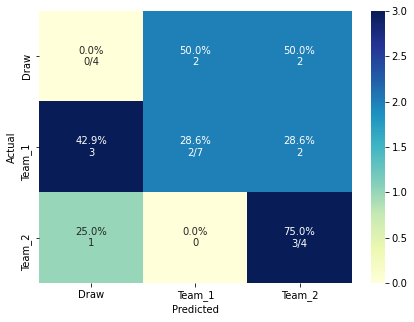

In [24]:
from xgboost import XGBClassifier

classifierX = XGBClassifier(max_depth = 6,learning_rate= 0.2, objective ='multi:softmax',subsample=0.7)
perform_cv_and_testing(classifierX,x_train,y_train,x_test,y_test)

In [25]:
from sklearn.metrics import accuracy_score
y_pred = classifierX.predict(x_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 33.33%


In [26]:
# Wrong Prediction
y_test[y_pred != y_test]  

Teams
Liverpool-Chelsea                      Draw
Liverpool-West Ham United            Team_1
Southampton-Liverpool                Team_2
Swansea City-Liverpool               Team_1
Liverpool-Burnley                      Draw
Manchester City-Leicester City       Team_1
Manchester City-Swansea City         Team_1
Manchester City-Tottenham Hotspur    Team_1
Newcastle United-Liverpool             Draw
Manchester City-Crystal Palace         Draw
Name: Winner, dtype: object

In [27]:
# Right Prediction
y_test[y_pred == y_test]   

Teams
Manchester United-Manchester City       Team_2
West Bromwich Albion-Manchester City    Team_2
Leicester City-Liverpool                Team_2
Manchester City-Swansea City            Team_1
Manchester City-West Bromwich Albion    Team_1
Name: Winner, dtype: object

#### Experiment 3.2 -  Analysis with the combination of two weak team ( Southhampton and Newcastle United)

In [28]:
filter_df2.Winner.value_counts()

Team_2    26
Team_1    26
Draw      22
Name: Winner, dtype: int64

In [29]:
x=filter_df2
y=filter_df2.Winner

In [30]:
del x['Winner']
del x['Team_1']
del x['Team_2']

In [32]:
# Split of dataset in test and train

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2 , random_state = 0)

------------------------------------------------------

k-fold CV Mean Accuracy 0.2533333333333333

------------------------------------------------------

------------------------------------------------------

Classificaion Report


              precision    recall  f1-score   support

        Draw       0.25      0.20      0.22         5
      Team_1       0.00      0.00      0.00         6
      Team_2       0.50      1.00      0.67         4

    accuracy                           0.33        15
   macro avg       0.25      0.40      0.30        15
weighted avg       0.22      0.33      0.25        15



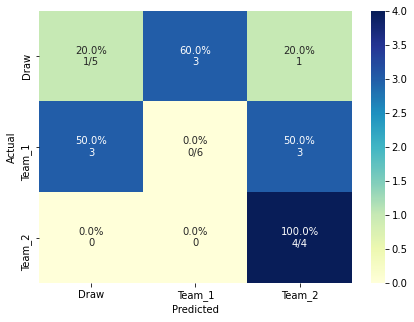

In [33]:
from xgboost import XGBClassifier

classifierX = XGBClassifier(max_depth = 6,learning_rate= 0.2, objective ='multi:softmax')
perform_cv_and_testing(classifierX,x_train,y_train,x_test,y_test)

In [34]:
from sklearn.metrics import accuracy_score
y_pred = classifierX.predict(x_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 33.33%


In [35]:
# Wrong Prediction
y_test[y_pred != y_test]

Teams
Watford-Newcastle United              Team_1
Burnley-Southampton                   Team_1
Newcastle United-Manchester United    Team_1
Arsenal-Southampton                     Draw
Southampton-Brighton & Hove Albion      Draw
Leicester City-Southampton            Team_1
Brighton & Hove Albion-Southampton      Draw
Chelsea-Southampton                   Team_1
Stoke City-Southampton                Team_1
Southampton-Manchester United           Draw
Name: Winner, dtype: object

In [36]:
# Right Prediction
y_test[y_pred == y_test]  

Teams
Newcastle United-Manchester City           Team_2
Crystal Palace-Southampton                 Team_2
Newcastle United-Manchester United         Team_2
Brighton & Hove Albion-Newcastle United      Draw
AFC Bournemouth-Southampton                Team_2
Name: Winner, dtype: object

#### Experiment 3.3 - Analysis with one strong team and one weak team ( Manchester City and Newcastle United)

In [37]:
filter_df3.Winner.value_counts()

Team_1    34
Team_2    28
Draw      12
Name: Winner, dtype: int64

In [38]:
x=filter_df3
y=filter_df3.Winner

In [39]:
del x['Winner']
del x['Team_1']
del x['Team_2']

In [40]:
# Split of dataset in test and train

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2 , random_state = 0)

------------------------------------------------------

k-fold CV Mean Accuracy 0.5633333333333332

------------------------------------------------------

------------------------------------------------------

Classificaion Report


              precision    recall  f1-score   support

        Draw       1.00      0.50      0.67         2
      Team_1       0.75      0.75      0.75         8
      Team_2       0.67      0.80      0.73         5

    accuracy                           0.73        15
   macro avg       0.81      0.68      0.71        15
weighted avg       0.76      0.73      0.73        15



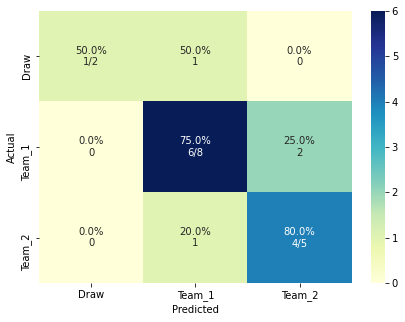

In [41]:
from xgboost import XGBClassifier

classifierX = XGBClassifier(max_depth = 6,learning_rate= 0.2, objective ='multi:softmax')
perform_cv_and_testing(classifierX,x_train,y_train,x_test,y_test)

In [42]:
from sklearn.metrics import accuracy_score
y_pred = classifierX.predict(x_test)


accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.33%


In [43]:
# Wrong Prediction list
y_test[y_pred != y_test]   

Teams
Burnley-Newcastle United             Team_1
Manchester City-Watford              Team_1
Manchester United-Manchester City    Team_2
Manchester City-Crystal Palace         Draw
Name: Winner, dtype: object

In [45]:
# Right Prediction List
y_test[y_pred == y_test]  

Teams
Newcastle United-Manchester United         Team_2
Newcastle United-Manchester United         Team_1
Newcastle United-Leicester City            Team_2
Newcastle United-Manchester City           Team_2
West Bromwich Albion-Manchester City       Team_2
Manchester City-Leicester City             Team_1
Brighton & Hove Albion-Newcastle United      Draw
West Bromwich Albion-Newcastle United      Team_1
Manchester City-Burnley                    Team_1
Manchester City-Swansea City               Team_1
Manchester City-Chelsea                    Team_1
Name: Winner, dtype: object